In [32]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install datetime

Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

import numpy as np
import math

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [39]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 9, 11)

In [40]:
df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-05,213.970001,211.509995,212.000000,213.279999,23913700.0,213.279999
2019-09-06,214.419998,212.509995,214.050003,213.259995,19362300.0,213.259995
2019-09-09,216.440002,211.070007,214.839996,214.169998,27309400.0,214.169998
2019-09-10,216.779999,211.710007,213.860001,216.699997,31777900.0,216.699997
2019-09-11,223.710007,217.729996,218.070007,223.589996,44289600.0,223.589996


In [41]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [42]:
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

'3.1.0'

In [43]:
style.use('ggplot')

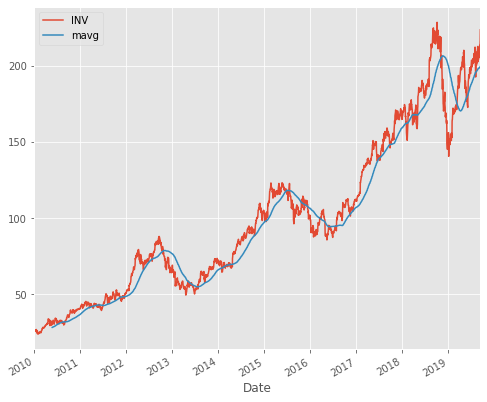

In [44]:
close_px.plot(label='INV')
mavg.plot(label='mavg')
plt.legend()

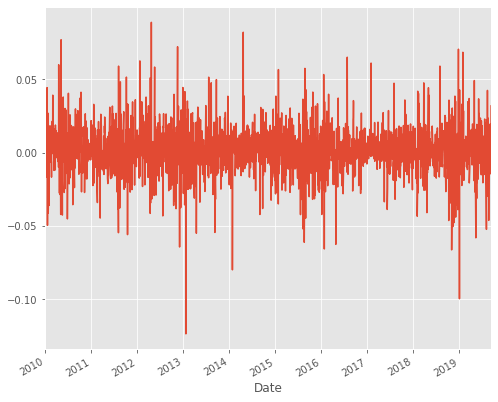

In [45]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [46]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [47]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

Text(0, 0.5, 'Returns GE')

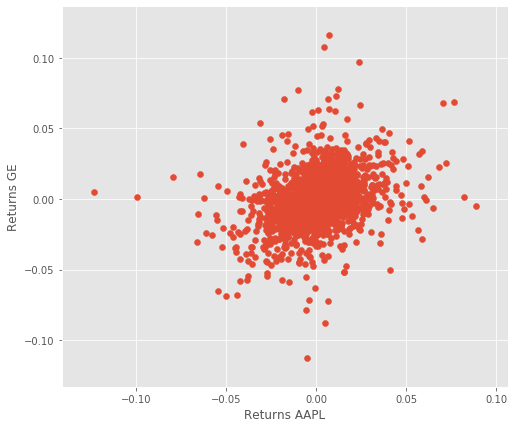

In [48]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

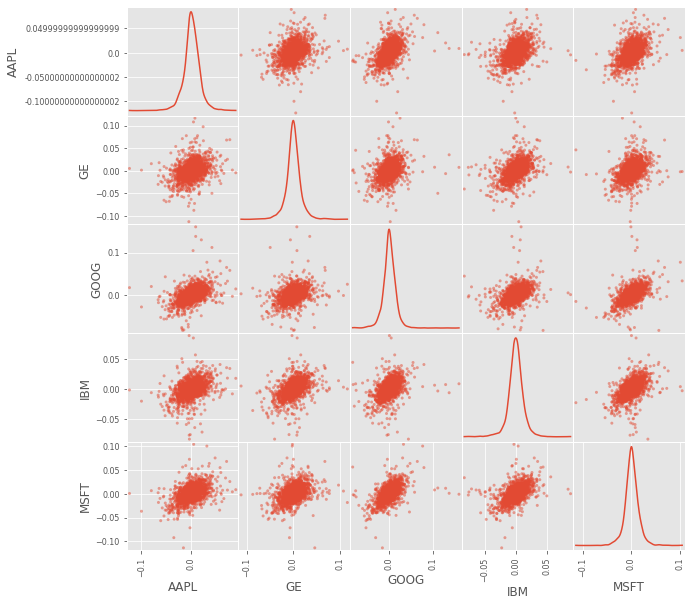

In [49]:
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

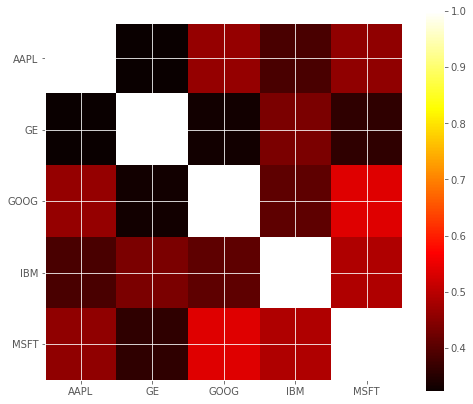

In [50]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

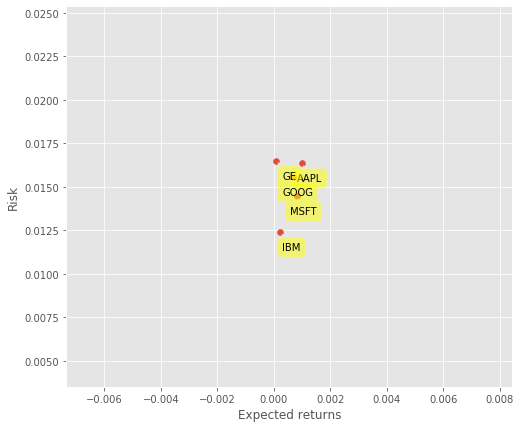

In [51]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [52]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [53]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [56]:
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [57]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [58]:
confidencereg

0.9652832100042975

In [59]:
confidencepoly2

0.9675107373400961

In [60]:
confidencepoly3

0.9642535400320579

In [61]:
confidenceknn

0.9512775001901116

In [64]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

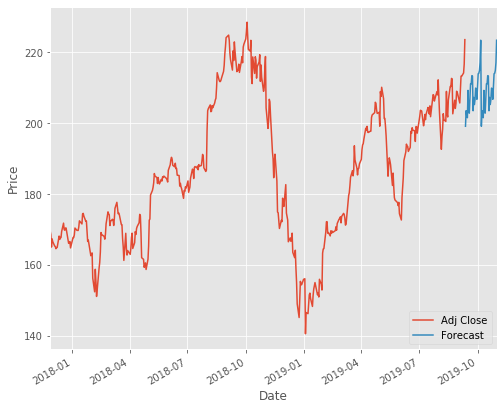

In [66]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()